In [326]:
import numpy as np
import pandas as pd
import sklearn

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

from tabulate import tabulate
from lib import features
from collections import defaultdict

import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
sns.set(font_scale=1)

In [327]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [328]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [329]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

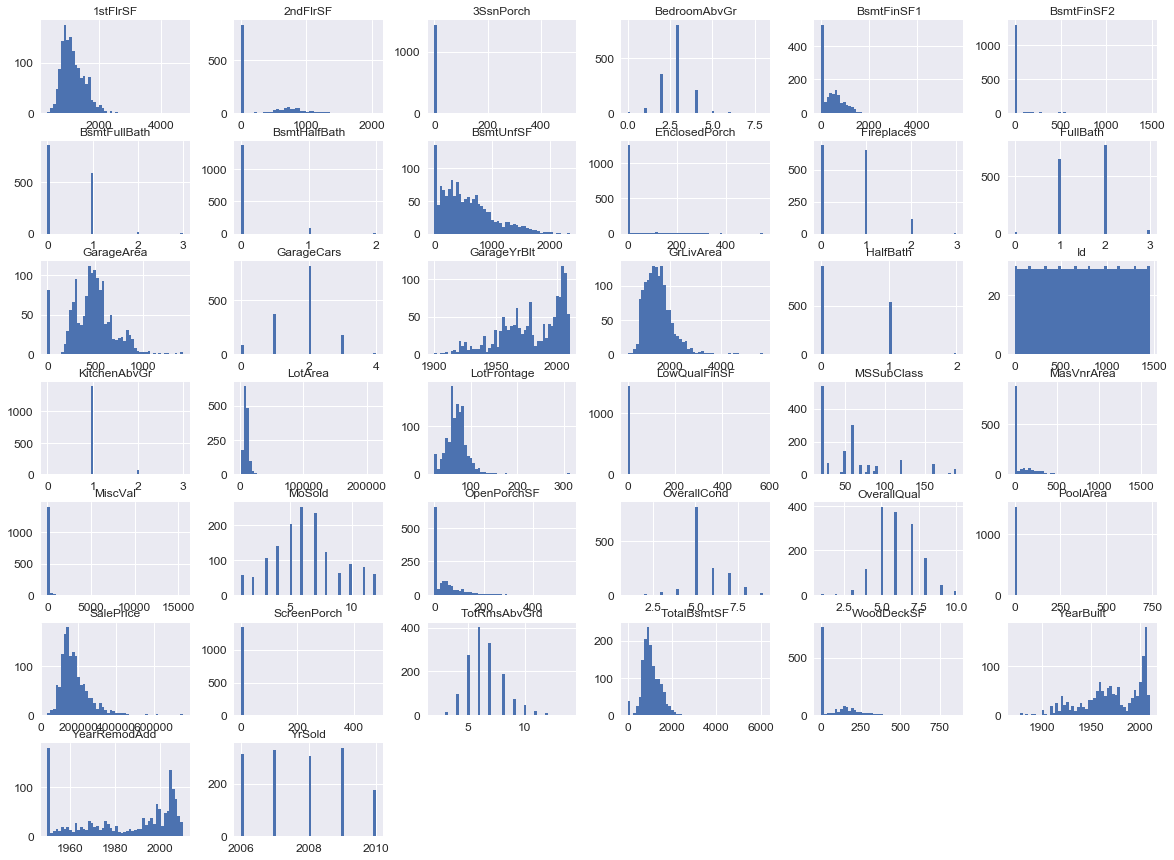

In [330]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import os

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

train.hist(bins=50, figsize=(20,15))
plt.show()

In [331]:
correlations=train.corr()
attrs = correlations.iloc[:-1,:-1] # all except target

threshold = 0.5
important_corrs = (attrs[abs(attrs) > threshold][attrs != 1.0]) \
    .unstack().dropna().to_dict()

unique_important_corrs = pd.DataFrame(
    list(set([(tuple(sorted(key)), important_corrs[key]) \
    for key in important_corrs])), 
        columns=['Attribute Pair', 'Correlation'])

    # sorted by absolute value
unique_important_corrs = unique_important_corrs.iloc[
    abs(unique_important_corrs['Correlation']).argsort()[::-1]]

unique_important_corrs

,Attribute Pair,Correlation
26,"(GarageArea, GarageCars)",0.882475
0,"(GarageYrBlt, YearBuilt)",0.825667
4,"(GrLivArea, TotRmsAbvGrd)",0.825489
6,"(1stFlrSF, TotalBsmtSF)",0.819530
27,"(2ndFlrSF, GrLivArea)",0.687501
2,"(BedroomAbvGr, TotRmsAbvGrd)",0.676620
10,"(BsmtFinSF1, BsmtFullBath)",0.649212
11,"(GarageYrBlt, YearRemodAdd)",0.642277
12,"(FullBath, GrLivArea)",0.630012
22,"(2ndFlrSF, TotRmsAbvGrd)",0.616423


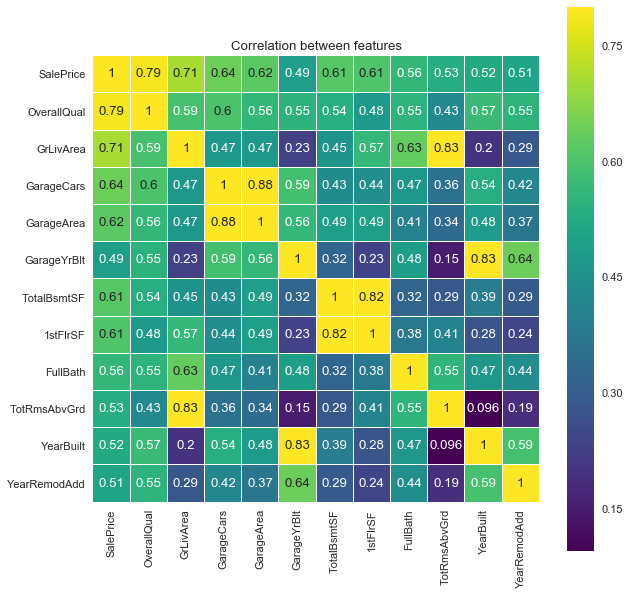

In [332]:
corrMatrix=train[["SalePrice","OverallQual","GrLivArea","GarageCars",
                  "GarageArea","GarageYrBlt","TotalBsmtSF","1stFlrSF","FullBath",
                  "TotRmsAbvGrd","YearBuilt","YearRemodAdd"]].corr()

sns.set(font_scale=1.10)
plt.figure(figsize=(10, 10))

sns.heatmap(corrMatrix, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='viridis',linecolor="white")
plt.title('Correlation between features');

In [333]:
matrix = train.corr()
matrix["SalePrice"].sort_values(ascending = False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

In [334]:
data = train.select_dtypes(include=[np.number]).interpolate().dropna()

y = np.log(data.SalePrice)
X = data.drop(["SalePrice", "Id"], axis=1)
names = X.columns

rf = RandomForestRegressor()
scores = defaultdict(list)

for train_idx, test_idx in sklearn.model_selection.ShuffleSplit(test_size=.3, n_splits=100).split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = y.iloc[train_idx], y.iloc[test_idx]
    r = rf.fit(X_train, Y_train)
    acc = r2_score(Y_test, rf.predict(X_test))
    for i in range(X.shape[1]):
        X_t = X_test.copy()
        np.random.shuffle(X_t.iloc[:, i].values)
        shuff_acc = r2_score(Y_test, rf.predict(X_t))
        scores[names[i]].append((acc - shuff_acc) / acc)
print("Mean decrease accuracy:")
for score, feature in sorted([(round(np.mean(score), 4), feat) for feat, score in scores.items()], reverse=True)[:5]:
    print(score, feature)

Mean decrease accuracy:
0.4415 OverallQual
0.1618 GrLivArea
0.0393 TotalBsmtSF
0.0224 YearBuilt
0.022 BsmtFinSF1


In [335]:
data = train.select_dtypes(include=[np.number]).interpolate().dropna()
X = data.drop(['SalePrice', 'Id'], axis=1)
y = np.log(train.SalePrice)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.33)

lr = linear_model.LinearRegression()

rfe = RFE(lr, 5)
fit = rfe.fit(X_train, y_train)
print("Features: {features}".format(features=X.columns))
print("Num Features: {number_features}".format(number_features=fit.n_features_))
print("Selected Features: {support}".format(support=fit.support_))
print("Feature Ranking: {ranking}".format(ranking=fit.ranking_))

selected_columns = [column for column, selected in zip(X.columns, fit.support_) if selected]
print("Selected columns: {selected}".format(selected = selected_columns))

Features: Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')
Num Features: 5
Selected Features: [False False False False False False False False  True  True  True  True
 False  True False False False False False False False False False False
 False False False False False False False False False False False False]
Feature Ranking: [20 22 32  7 13 16 18 30  1  1  1  1  2  1  4  3  8 12  9 10 15  5 14 11 23
  6 29 27 28 26 25 24 21 31 17 19]
Selected columns: ['BsmtFinS

In [336]:
train[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF']].head()

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF
0,706,0,150,856,854
1,978,0,284,1262,0
2,486,0,434,920,866
3,216,0,540,756,756
4,655,0,490,1145,1053


In [337]:
train["GarageArea"].corr(train["GarageCars"])
# No point having both of these given how similar they are

0.88247541428146203

In [338]:
train[["GarageArea", "GarageCars"]].head()

,GarageArea,GarageCars
0,548,2
1,460,2
2,608,2
3,642,3
4,836,3


In [339]:
combined_sf = train.copy()
combined_sf["TotalSF"] = combined_sf["1stFlrSF"] + combined_sf["2ndFlrSF"]
print(combined_sf[["TotalSF", "1stFlrSF", "2ndFlrSF"]].head())
print("Correlation", combined_sf["TotalSF"].corr(combined_sf["SalePrice"]))
print(combined_sf.corr()["TotalSF"].sort_values(ascending = False))
# GrLiveArea and TotalSF are almost identical - only need to keep one of them

   TotalSF  1stFlrSF  2ndFlrSF
0     1710       856       854
1     1262      1262         0
2     1786       920       866
3     1717       961       756
4     2198      1145      1053
Correlation 0.716883079369
TotalSF          1.000000
GrLivArea        0.995718
TotRmsAbvGrd     0.820088
SalePrice        0.716883
2ndFlrSF         0.687285
FullBath         0.635296
OverallQual      0.600758
1stFlrSF         0.572041
BedroomAbvGr     0.515734
GarageCars       0.479932
GarageArea       0.479189
Fireplaces       0.467488
TotalBsmtSF      0.461738
HalfBath         0.421742
LotFrontage      0.403280
MasVnrArea       0.400582
OpenPorchSF      0.331256
YearRemodAdd     0.295593
LotArea          0.264850
WoodDeckSF       0.251856
BsmtUnfSF        0.239619
GarageYrBlt      0.235159
YearBuilt        0.217805
BsmtFinSF1       0.215913
PoolArea         0.165816
KitchenAbvGr     0.100190
ScreenPorch      0.099851
MSSubClass       0.071137
MoSold           0.052725
LowQualFinSF     0.042501
BsmtFul

In [340]:
combined_bath = train.copy()
train["FullBath"].corr(train["HalfBath"])
combined_bath["TotalBath"] = combined_bath["FullBath"] + (0.5 * combined_bath["HalfBath"])
print(combined_bath[["TotalBath", "FullBath", "HalfBath"]].head())
print("Correlation", combined_bath["TotalBath"].corr(combined_bath["SalePrice"]))
print(combined_bath.corr()["TotalBath"].sort_values(ascending = False))
# has quite a strong correlation with GrLivArea so perhaps we don't need both of them

   TotalBath  FullBath  HalfBath
0        2.5         2         1
1        2.0         2         0
2        2.5         2         1
3        1.0         1         0
4        2.5         2         1
Correlation 0.597965621006
TotalBath        1.000000
FullBath         0.920116
GrLivArea        0.710087
TotRmsAbvGrd     0.616319
2ndFlrSF         0.606039
SalePrice        0.597966
OverallQual      0.585038
HalfBath         0.513473
YearBuilt        0.501547
GarageYrBlt      0.498549
GarageCars       0.493479
YearRemodAdd     0.452780
GarageArea       0.416037
BedroomAbvGr     0.404253
MasVnrArea       0.319294
OpenPorchSF      0.304158
Fireplaces       0.291578
1stFlrSF         0.282300
TotalBsmtSF      0.261114
BsmtUnfSF        0.233977
WoodDeckSF       0.205317
LotFrontage      0.194845
MSSubClass       0.184114
LotArea          0.114805
KitchenAbvGr     0.088317
BsmtFinSF1       0.052395
PoolArea         0.051815
MoSold           0.044819
3SsnPorch        0.028657
ScreenPorch      0.02

In [341]:
def create_linear_model(data):
    y = np.log(train.SalePrice)
    X = data.drop(['SalePrice', 'Id'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.33)
    lr = linear_model.LinearRegression()
    model = lr.fit(X_train, y_train)
    return model, X_test, y_test

def test_model(model, X_test, y_test):
    return model.score(X_test, y_test), np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

In [342]:
def clean_nulls(data):
    new_data = data.copy()

    new_data["MasVnrType"] = new_data["MasVnrType"].fillna('None')
    new_data["MasVnrArea"] = new_data["MasVnrArea"].fillna(0.0)
    new_data["Alley"] = new_data["Alley"].fillna('None')
    basement_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2']
    for col in basement_cols:
        if 'FinSF' not in col:
            new_data[col] = new_data[col].fillna('None')
    new_data["FireplaceQu"] = new_data["FireplaceQu"].fillna('None')
    garage_cols = ['GarageType', 'GarageQual', 'GarageCond', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea']
    for col in garage_cols:
        if new_data[col].dtype == np.object:
            new_data[col] = new_data[col].fillna('None')
        else:
            new_data[col] = new_data[col].fillna(0)
    new_data.Fence = new_data.Fence.fillna("None")
    new_data.MiscFeature = new_data.MiscFeature.fillna("None")

    missing_lot_frontage = new_data['LotFrontage'].isnull()
    new_data['SqrtLotArea'] = np.sqrt(new_data['LotArea'])
    # new_data.LotFrontage[missing_lot_frontage] = new_data.SqrtLotArea[missing_lot_frontage]

    new_data.loc[missing_lot_frontage, "LotFrontage"] = new_data.loc[missing_lot_frontage, "SqrtLotArea"]

    new_data["PoolQC"] = new_data["PoolQC"].fillna('None')
    new_data["Electrical"] = new_data["Electrical"].fillna('SBrkr')

    return new_data.drop(["SqrtLotArea"], axis=1)

In [343]:
def enc_condition(x): return 1 if x == 'Partial' else 0


def foundation(x): return 1 if x == 'PConc' else 0


def misc_feature(x): return 1 if x == 'TenC' else 0


def fireplace(x): return 1 if x == "Ex" else 0


def exterior(x):
    if x == "Ex":
        return 5
    elif x == "Gd":
        return 4
    elif x == "TA":
        return 3
    elif x == "Fa":
        return 2
    else:
        return 1


def add_features(data):
    new_data = data.copy()
    new_data['enc_street'] = pd.get_dummies(new_data.Street, drop_first=True)
    new_data['enc_condition'] = new_data.SaleCondition.apply(enc_condition)
    new_data['enc_foundation'] = new_data.Foundation.apply(foundation)
    new_data['enc_misc_feature'] = new_data.MiscFeature.apply(misc_feature)
    new_data['enc_central_air'] = pd.get_dummies(new_data.CentralAir, drop_first=True)
    new_data['enc_fireplace'] = new_data.FireplaceQu.apply(misc_feature)
    new_data['enc_exterior'] = new_data.ExterCond.apply(exterior)
    return new_data

In [344]:
table = []
headers = ["type", "R squared", "RMSE"]

model, X_test, y_test = create_linear_model(train.select_dtypes(include=[np.number]).interpolate().dropna())
table.append(["Linear: All numeric"] + list(test_model(model, X_test, y_test)))

cleaned_train = clean_nulls(train)
model, X_test, y_test = create_linear_model(cleaned_train.select_dtypes(include=[np.number]).interpolate().dropna())
table.append(["Linear: All numeric (clean)"] + list(test_model(model, X_test, y_test)))

combined_train = train.copy()
combined_train["TotalSF"] = combined_train["1stFlrSF"] + combined_train["2ndFlrSF"] + combined_train["TotalBsmtSF"]
combined_train["TotalBath"] = combined_train["FullBath"] + (0.5 * combined_train["HalfBath"])

model, X_test, y_test = create_linear_model(combined_train[['SalePrice', 'Id', 'OverallQual', 'OverallCond', 'GrLivArea', 'GarageArea', "YearBuilt"]])
table.append(["Linear: Hand picked"] + list(test_model(model, X_test, y_test)))

# trying with the r2_score function
print(r2_score(y_test, model.predict(X_test)))
print(model.score(X_test, y_test))

print(mean_squared_error(model.predict(X_test), y_test))

print(tabulate(table, headers, tablefmt="plain"))

0.848766269293
0.848766269293
0.0257749739283
type                           R squared      RMSE
Linear: All numeric             0.862755  0.152941
Linear: All numeric (clean)     0.863544  0.1525
Linear: Hand picked             0.848766  0.160546


In [345]:
combined_train_features = add_features(combined_train)
combined_train_features.head()
combined_train_features.select_dtypes(include=[np.object]).head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [346]:
numeric = train.select_dtypes(include=[np.number]).interpolate().dropna()

non_numeric_columns = set(train.columns.tolist()) - set(numeric.columns.tolist())
for column in list(non_numeric_columns):
    print(column, train[column].value_counts(dropna=False).to_dict())

LandContour {'Lvl': 1311, 'Bnk': 63, 'HLS': 50, 'Low': 36}
LotShape {'Reg': 925, 'IR1': 484, 'IR2': 41, 'IR3': 10}
Exterior2nd {'VinylSd': 504, 'MetalSd': 214, 'HdBoard': 207, 'Wd Sdng': 197, 'Plywood': 142, 'CmentBd': 60, 'Wd Shng': 38, 'Stucco': 26, 'BrkFace': 25, 'AsbShng': 20, 'ImStucc': 10, 'Brk Cmn': 7, 'Stone': 5, 'AsphShn': 3, 'Other': 1, 'CBlock': 1}
BldgType {'1Fam': 1220, 'TwnhsE': 114, 'Duplex': 52, 'Twnhs': 43, '2fmCon': 31}
HeatingQC {'Ex': 741, 'TA': 428, 'Gd': 241, 'Fa': 49, 'Po': 1}
ExterQual {'TA': 906, 'Gd': 488, 'Ex': 52, 'Fa': 14}
KitchenQual {'TA': 735, 'Gd': 586, 'Ex': 100, 'Fa': 39}
RoofStyle {'Gable': 1141, 'Hip': 286, 'Flat': 13, 'Gambrel': 11, 'Mansard': 7, 'Shed': 2}
Alley {nan: 1369, 'Grvl': 50, 'Pave': 41}
GarageType {'Attchd': 870, 'Detchd': 387, 'BuiltIn': 88, nan: 81, 'Basment': 19, 'CarPort': 9, '2Types': 6}
GarageFinish {'Unf': 605, 'RFn': 422, 'Fin': 352, nan: 81}
SaleType {'WD': 1267, 'New': 122, 'COD': 43, 'ConLD': 9, 'ConLI': 5, 'ConLw': 5, 'CWD':

In [347]:
def pivot_me(index_name):
    pivot = train.pivot_table(index=index_name, values='SalePrice', aggfunc=np.median)

    sns.barplot(y="SalePrice", data=pivot)

In [348]:
# from math import ceil

# fig, axs = plt.subplots(ncols=2)

# sns.distplot(np.log(train["SalePrice"]), color='r', kde=False, ax=axs[0])
# sns.distplot(train["SalePrice"], color='r', kde=False, ax=axs[1])
# sns.plt.show()

# for column in list(non_numeric_columns):
#     pivot_me(column)
# plt.show()

# for index, column in enumerate(list(non_numeric_columns)[:1]):
#     print(column)
#     pivot = train.pivot_table(index=column, values='SalePrice', aggfunc=np.median)
#     print(pivot)
#     sns.barplot(y="SalePrice", data=pivot, ax=axs[index])
#     sns.plt.show()

In [349]:
pd.get_dummies(train["MSZoning"]).corrwith(train["SalePrice"])

C (all)   -0.111257
FV         0.089950
RH        -0.065429
RL         0.245063
RM        -0.288065
dtype: float64

In [350]:
def residential(x): return 1 if x == "RL" else 0
combined_train["enc_quiet_residential"] = combined_train["MSZoning"].apply(residential)
combined_train.corr()["enc_quiet_residential"].sort_values(ascending=False)

enc_quiet_residential    1.000000
LotFrontage              0.346736
1stFlrSF                 0.304731
YearBuilt                0.268064
TotalBsmtSF              0.257373
SalePrice                0.245063
TotalSF                  0.228050
Fireplaces               0.227465
BsmtFinSF1               0.206887
LotArea                  0.204065
GarageCars               0.175167
GarageArea               0.169593
WoodDeckSF               0.167734
BsmtFullBath             0.146855
TotRmsAbvGrd             0.145513
BedroomAbvGr             0.139264
GarageYrBlt              0.134148
GrLivArea                0.132936
TotalBath                0.129916
OverallQual              0.126972
FullBath                 0.123634
MasVnrArea               0.091688
BsmtFinSF2               0.082900
YearRemodAdd             0.074221
BsmtHalfBath             0.068697
ScreenPorch              0.061666
HalfBath                 0.057734
3SsnPorch                0.051525
PoolArea                 0.035591
Id            

In [351]:
table = []
cols = ['SalePrice', 'Id', 'OverallQual', 'OverallCond', 'GrLivArea', 'GarageArea', "YearBuilt", "enc_quiet_residential"]

model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked residential"] + list(test_model(model, X_test, y_test)))
print(tabulate(table, headers, tablefmt="plain"))

type                               R squared      RMSE
Linear: Hand picked residential     0.862234  0.153231


In [352]:
combined_train.corr()["YearBuilt"].sort_values(ascending = False)

YearBuilt                1.000000
GarageYrBlt              0.825667
YearRemodAdd             0.592855
OverallQual              0.572323
GarageCars               0.537850
SalePrice                0.522897
TotalBath                0.501547
GarageArea               0.478954
FullBath                 0.468271
TotalBsmtSF              0.391452
TotalSF                  0.347133
MasVnrArea               0.315707
1stFlrSF                 0.281986
enc_quiet_residential    0.268064
BsmtFinSF1               0.249503
HalfBath                 0.242656
WoodDeckSF               0.224880
GrLivArea                0.199010
OpenPorchSF              0.188686
BsmtFullBath             0.187599
BsmtUnfSF                0.149040
Fireplaces               0.147716
LotFrontage              0.123349
TotRmsAbvGrd             0.095589
3SsnPorch                0.031355
MSSubClass               0.027850
LotArea                  0.014228
MoSold                   0.012398
2ndFlrSF                 0.010308
PoolArea      

In [353]:
cols = ["YearBuilt", "YearRemodAdd", "GarageYrBlt"]
combined_train["LastWorkDoneYear"] = combined_train[cols].max(axis=1)
combined_train[(cols + ["LastWorkDoneYear"])].head()
combined_train.corr()["LastWorkDoneYear"].sort_values(ascending=False)

LastWorkDoneYear         1.000000
YearRemodAdd             0.954920
GarageYrBlt              0.700167
YearBuilt                0.552209
OverallQual              0.518769
SalePrice                0.482379
GarageCars               0.436792
TotalBath                0.423458
FullBath                 0.414271
GarageArea               0.408204
TotalSF                  0.317986
GrLivArea                0.271104
TotalBsmtSF              0.268011
1stFlrSF                 0.218442
OpenPorchSF              0.211711
WoodDeckSF               0.191670
TotRmsAbvGrd             0.186163
BsmtUnfSF                0.178410
HalfBath                 0.163446
MasVnrArea               0.156551
2ndFlrSF                 0.135773
BsmtFinSF1               0.108841
BsmtFullBath             0.102778
Fireplaces               0.083276
LotFrontage              0.074371
OverallCond              0.073877
enc_quiet_residential    0.043228
3SsnPorch                0.040866
YrSold                   0.035595
MSSubClass    

In [355]:
table = []

cols = ['SalePrice', 'Id', 'OverallQual', 'OverallCond', 'GrLivArea', 'GarageArea', "YearBuilt"]
model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked (base)"] + list(test_model(model, X_test, y_test)))

cols = ['SalePrice', 'Id', 'OverallQual', 'OverallCond', 'GrLivArea', 'GarageArea', "YearBuilt", "enc_quiet_residential"]
model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked res"] + list(test_model(model, X_test, y_test)))

cols = ['SalePrice', 'Id', 'OverallQual', 'OverallCond', 'GrLivArea', 'GarageArea', "YearBuilt", "enc_quiet_residential", "LastWorkDoneYear"]
model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked res/work done"] + list(test_model(model, X_test, y_test)))

cols = ['SalePrice', 'Id', 'OverallQual', 'OverallCond', 'GrLivArea', 'GarageArea', "YearBuilt", \
        "enc_quiet_residential", "LastWorkDoneYear", "TotalBath"]
model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked res/work done/bath"] + list(test_model(model, X_test, y_test)))

cols = ['SalePrice', 'Id', 'OverallQual', 'OverallCond', 'GrLivArea', 'GarageArea', "YearBuilt", \
        "enc_quiet_residential", "LastWorkDoneYear", "TotalBath", "TotalSF"]
model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked res/work done/bath/floor space"] + list(test_model(model, X_test, y_test)))

cols = ['SalePrice', 'Id', 'OverallQual', 'OverallCond', 'GrLivArea', 'GarageArea', "YearBuilt", \
        "enc_quiet_residential", "TotalBath", "TotalSF"]
model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked res/bath/floor space"] + list(test_model(model, X_test, y_test)))

cols = ['SalePrice', 'Id', 'OverallQual', 'OverallCond', 'GarageArea', "YearBuilt", \
        "enc_quiet_residential", "TotalBath", "TotalSF"]
model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked res/bath/floor space - GrLivArea"] + list(test_model(model, X_test, y_test)))

cols = ['SalePrice', 'Id', 'OverallCond', 'GarageArea', "YearBuilt", \
        "enc_quiet_residential", "TotalBath", "TotalSF"]
model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked res/bath/floor space - OverallQual"] + list(test_model(model, X_test, y_test)))

print(tabulate(table, headers, tablefmt="plain"))

combined_train.corr()["PoolArea"].sort_values(ascending=False)

type                                                      R squared      RMSE
Linear: Hand picked (base)                                 0.848766  0.160546
Linear: Hand picked res                                    0.862234  0.153231
Linear: Hand picked res/work done                          0.860863  0.153991
Linear: Hand picked res/work done/bath                     0.861288  0.153756
Linear: Hand picked res/work done/bath/floor space         0.874776  0.146089
Linear: Hand picked res/bath/floor space                   0.875799  0.145491
Linear: Hand picked res/bath/floor space - GrLivArea       0.873434  0.14687
Linear: Hand picked res/bath/floor space - OverallQual     0.846151  0.161928


PoolArea                 1.000000
LotFrontage              0.206167
TotalSF                  0.172466
GrLivArea                0.170205
BsmtFinSF1               0.140491
1stFlrSF                 0.131525
TotalBsmtSF              0.126053
Fireplaces               0.095074
SalePrice                0.092404
TotRmsAbvGrd             0.083757
2ndFlrSF                 0.081487
LotArea                  0.077672
WoodDeckSF               0.073378
BedroomAbvGr             0.070703
BsmtFullBath             0.067616
OverallQual              0.065166
LowQualFinSF             0.062157
GarageArea               0.061047
OpenPorchSF              0.060762
Id                       0.057044
EnclosedPorch            0.054203
TotalBath                0.051815
ScreenPorch              0.051307
FullBath                 0.049604
BsmtFinSF2               0.041709
enc_quiet_residential    0.035591
MiscVal                  0.029669
HalfBath                 0.022381
GarageCars               0.020934
BsmtHalfBath  

In [356]:
combined_train["Fence"] = combined_train["Fence"].fillna('None')
combined_train["Fence"].value_counts(dropna=False)
pd.get_dummies(combined_train["Fence"]).corrwith(combined_train["SalePrice"])
# this one seems like a bit of a dead end - there are too few actual values to find anything interesting

GdPrv   -0.005152
GdWo    -0.100047
MnPrv   -0.140613
MnWw    -0.051164
None     0.172184
dtype: float64

In [323]:
def very_nice_kitchen(x): return 1 if x == "Ex" else 0
def nice_kitchen(x): return 1 if x == "Gd" else 0

print(pd.get_dummies(combined_train["KitchenQual"]).corrwith(combined_train["SalePrice"]))

combined_train["enc_very_nice_kitchen"] = combined_train["KitchenQual"].apply(very_nice_kitchen)
combined_train["enc_nice_kitchen"] = combined_train["KitchenQual"].apply(nice_kitchen)
combined_train.corr()["enc_nice_kitchen"].sort_values(ascending=False)
# Maybe the remod is for a kitchen? 

Ex    0.504094
Fa   -0.157199
Gd    0.321641
TA   -0.519298
dtype: float64


enc_nice_kitchen         1.000000
YearRemodAdd             0.533628
YearBuilt                0.435315
GarageYrBlt              0.425990
OverallQual              0.409134
TotalBath                0.375126
FullBath                 0.372642
GarageCars               0.337548
SalePrice                0.321641
GarageArea               0.291626
TotalSF                  0.241115
enc_is_new               0.238883
GrLivArea                0.226253
TotalBsmtSF              0.173052
2ndFlrSF                 0.162119
BsmtUnfSF                0.161460
OpenPorchSF              0.160655
WoodDeckSF               0.160142
1stFlrSF                 0.133058
HalfBath                 0.132402
TotRmsAbvGrd             0.110562
Fireplaces               0.103586
MasVnrArea               0.093848
BsmtFullBath             0.066668
LotFrontage              0.054340
MoSold                   0.043096
PoolArea                 0.027842
BsmtFinSF1               0.023041
MSSubClass               0.022411
Id            

In [322]:
table = []
cols = ['SalePrice', 'Id', 'OverallCond', 'GarageArea', "YearBuilt", \
        "enc_quiet_residential", "TotalBath", "TotalSF"]
model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked res/bath/floor space - OverallQual"] + list(test_model(model, X_test, y_test)))

cols = ['SalePrice', 'Id', 'OverallCond', 'GarageArea', "YearBuilt", \
        "enc_quiet_residential", "TotalBath", "TotalSF", "enc_very_nice_kitchen", "enc_nice_kitchen"]
model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked res/bath/floor space/kitchen - OverallQual"] + list(test_model(model, X_test, y_test)))

print(tabulate(table, headers, tablefmt="plain"))

KeyError: "['enc_quiet_residential'] not in index"

In [321]:
print(combined_train["Functional"].value_counts())
pd.get_dummies(combined_train["Functional"]).corrwith(combined_train["SalePrice"])

def has_damage(x): return 0 if x == "Typ" else 1
combined_train["enc_has_damage"] = combined_train["Functional"].apply(has_damage)

Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64


In [320]:
table = []
cols = ['SalePrice', 'Id', 'OverallCond', 'GarageArea', "YearBuilt", \
        "enc_quiet_residential", "TotalBath", "TotalSF"]
model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked res/bath/floor space - OverallQual"] + list(test_model(model, X_test, y_test)))

cols = ['SalePrice', 'Id', 'OverallCond', 'GarageArea', "YearBuilt", \
        "enc_quiet_residential", "TotalBath", "TotalSF", "enc_very_nice_kitchen", "enc_nice_kitchen"]
model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked res/bath/floor space/kitchen - OverallQual"] + list(test_model(model, X_test, y_test)))


cols = ['SalePrice', 'Id', 'OverallCond', 'GarageArea', "YearBuilt", \
        "enc_quiet_residential", "TotalBath", "TotalSF", "enc_very_nice_kitchen", "enc_nice_kitchen", "enc_has_damage"]
model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked res/bath/floor space/kitchen/damage - OverallQual"] + list(test_model(model, X_test, y_test)))

print(tabulate(table, headers, tablefmt="plain"))

KeyError: "['enc_quiet_residential'] not in index"

In [294]:
print(combined_train["LotShape"].value_counts())
pd.get_dummies(combined_train["LotShape"]).corrwith(combined_train["SalePrice"])
# Don't understand this. Seems odd that the price would be lower if the land is a regular shape?

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64


IR1    0.223284
IR2    0.126096
IR3    0.036720
Reg   -0.267672
dtype: float64

In [318]:
print(combined_train["MSSubClass"].value_counts())
print(pd.get_dummies(combined_train["MSSubClass"]).corrwith(combined_train["SalePrice"]))

def is_new(x): return 1 if x == 60 else 0
combined_train["enc_is_new"] = combined_train["MSSubClass"].apply(is_new)

combined_train.corr()["enc_is_new"].sort_values(ascending = True)
combined_train["enc_is_new"].value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64
20     0.041274
30    -0.238640
40    -0.016366
45    -0.082912
50    -0.156692
60     0.377197
70    -0.036883
75     0.015265
80    -0.028646
85    -0.049137
90    -0.114655
120    0.062944
160   -0.113042
180   -0.082215
190   -0.093578
dtype: float64


0    1161
1     299
Name: enc_is_new, dtype: int64

In [319]:
table = []
cols = ['SalePrice', 'Id', 'OverallCond', 'GarageArea', "YearBuilt", \
        "enc_quiet_residential", "TotalBath", "TotalSF", "enc_very_nice_kitchen", \
        "enc_nice_kitchen", "enc_has_damage", "enc_is_new"]
model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked res/bath/floor space/kitchen/damage - OverallQual"] + list(test_model(model, X_test, y_test)))

print(tabulate(table, headers, tablefmt="plain"))

KeyError: "['enc_quiet_residential' 'enc_very_nice_kitchen' 'enc_nice_kitchen'\n 'enc_has_damage'] not in index"

In [297]:
combined_train["MSSubClass"].value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

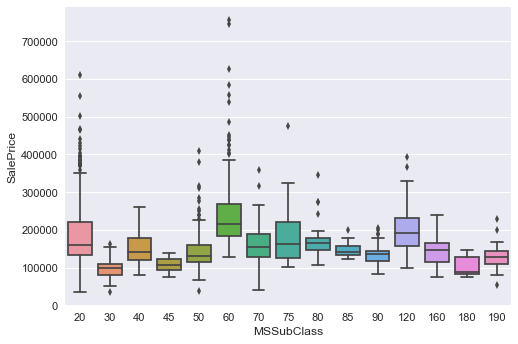

In [298]:
sns.boxplot("MSSubClass","SalePrice",data=combined_train);

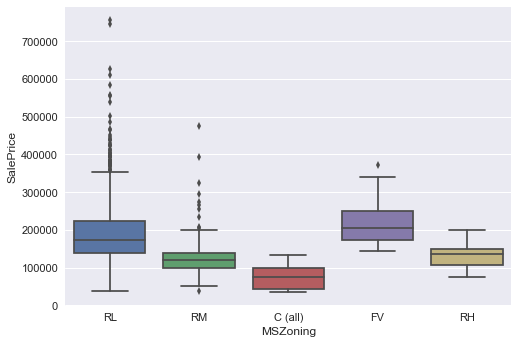

In [299]:
sns.boxplot("MSZoning", "SalePrice",data=combined_train)

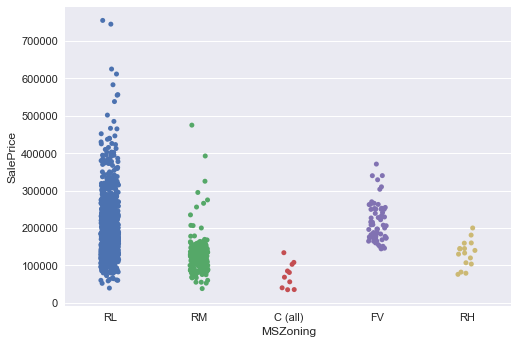

In [300]:
sns.stripplot(x=combined_train["MSZoning"], y=combined_train["SalePrice"],jitter=True);

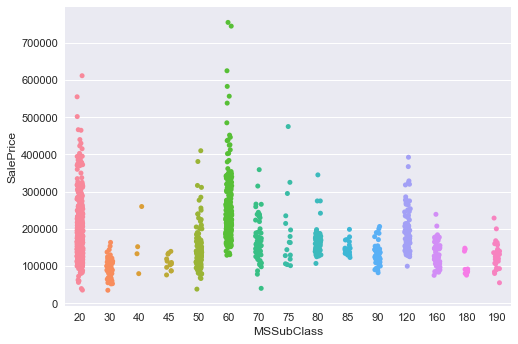

In [301]:
sns.stripplot(x=combined_train["MSSubClass"], y=combined_train["SalePrice"],jitter=True);

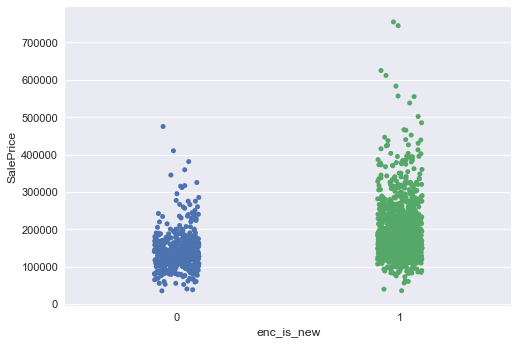

In [302]:
def is_new(x): return 1 if x in [20, 60, 120, 160] else 0
combined_train["enc_is_new"] = combined_train["MSSubClass"].apply(is_new)
sns.stripplot(x=combined_train["enc_is_new"], y=combined_train["SalePrice"],jitter=True);

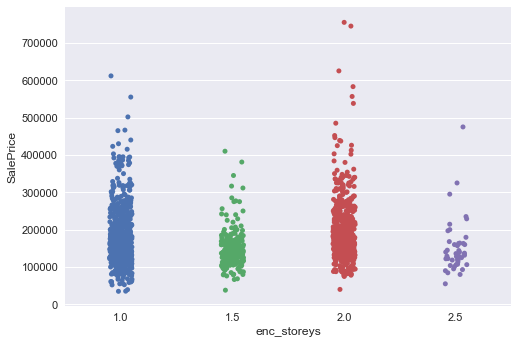

In [303]:
def storeys(x): 
    if x in [20, 30, 40, 120]:
        return 1.0
    elif x in [45, 50, 80, 85, 150]:
        return 1.5
    elif x in [60,70,90, 160, 180]:
        return 2.0
    elif x in [75, 190]:
        return 2.5
    else:
        return 0

combined_train["enc_storeys"] = combined_train["MSSubClass"].apply(storeys)
sns.stripplot(x=combined_train["enc_storeys"], y=combined_train["SalePrice"],jitter=True);